In [9]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import numpy as np
from scipy.signal import convolve2d
import math
import warnings

### Que contient ce notebook ?

Ce notebook permet de tester de manière interactive la pipeline de défloutage mise en place dans notre travail. Il n'est PAS redondant avec les fichiers .py, bien que certaines fonctions soient communes.

Attention ! Ce code notebook peut être gourmand en ressources, il est conseillé de l'executer sur une machine professionelle, ou de réduire certains paramètres de résolution dans les fonctions de test.

#### Floutage par une PSF constante

In [10]:
def blur_image(image, psf, mode = "same"):
   output = image.copy()
   if len(image.shape) == 3:
    for i in range(3):
       output[:,:,i] = convolve2d(image[:,:,i], psf, mode=mode)
   else:
       output = convolve2d(image, psf, mode=mode)
   
   return output

#### Générateurs d'images simulées

In [11]:
def generate_star_field(image_shape=(256, 256, 3), num_stars=10, star_intensity=(0.5, 1), star_radius=3):
    """
    Génère une image simulant un champ d'étoiles aléatoires.

    Parameters:
    - image_shape: tuple (hauteur, largeur), taille de l'image.
    - num_stars: int, nombre d'étoiles à générer.
    - star_intensity: tuple (min, max), plage d'intensités pour les étoiles (valeurs en niveaux de gris).
    - star_radius: int, rayon des étoiles (en pixels).

    Returns:
    - star_field: numpy array, image du champ d'étoiles.
    """
    # Crée une image noire
    star_field = np.zeros(image_shape, dtype=np.float32)

    # Génère des positions aléatoires pour les étoiles
    height, width = image_shape[:2]
    star_positions = np.random.randint(0, min(height, width), size=(num_stars, 2))

    # Ajoute des étoiles au champ
    for pos in star_positions:
        y, x = pos
        # Ajuste l'intensité et applique un rayon (disque 2D)
        intensity = np.random.uniform(star_intensity[0], star_intensity[1])
        y_coords, x_coords = np.ogrid[:height, :width]
        distance = np.sqrt((y_coords - y)**2 + (x_coords - x)**2)
        star_field[distance <= star_radius] += intensity

    # Clip pour rester dans des valeurs valides
    star_field = np.clip(star_field, 0, 255)

    return star_field, star_positions

In [12]:
import math
import warnings

def generate_spaced_star_field(
    image_shape=(256, 256, 3),
    num_stars=10,
    star_intensity=(0.5, 1),
    star_radius=3,
    border_margin_fraction=1/30,
    star_separation_fraction=1/20 # NOUVEAU: Distance min entre étoiles
    ):
    """
    Génère une image simulant un champ d'étoiles aléatoires, en s'assurant
    qu'elles sont éloignées des bords ET les unes des autres.
    Utilise une méthode de type "Dart Throwing" (Simple Sequential Inhibition).

    Parameters:
    - image_shape: tuple (hauteur, largeur, [canaux]), taille de l'image.
    - num_stars: int, nombre d'étoiles à générer.
    - star_intensity: tuple (min, max), plage d'intensités pour les étoiles.
    - star_radius: int, rayon des étoiles (en pixels).
    - border_margin_fraction: float, fraction de la dimension de l'image servant de
                              marge minimale par rapport au bord.
    - star_separation_fraction: float, fraction de la plus petite dimension de l'image
                                servant de distance minimale entre les centres des étoiles.

    Returns:
    - star_field: numpy array (float32), image du champ d'étoiles.
    - star_positions: numpy array (int), positions (y, x) des étoiles générées.

    Raises:
    - ValueError: Si la marge au bord demandée est trop grande par rapport à la taille
                  de l'image.

    Issues:
    - RuntimeWarning: Si toutes les étoiles demandées n'ont pas pu être placées
                      en respectant les contraintes (max_attempts atteint).
                      Peut être lent si num_stars est élevé et/ou les contraintes
                      sont fortes.
    """
    # Crée une image noire
    star_field = np.zeros(image_shape, dtype=np.float32)
    height, width = image_shape[:2]

    # --- 1. Calcul des contraintes de distance ---

    # -- Contrainte 1: Distance minimale aux bords --
    min_margin_y = math.ceil(height * border_margin_fraction)
    min_margin_x = math.ceil(width * border_margin_fraction)

    # Zone valide pour les centres (respectant les bords)
    min_y_zone = min_margin_y
    max_y_zone = height - 1 - min_margin_y # Indice max valide
    min_x_zone = min_margin_x
    max_x_zone = width - 1 - min_margin_x   # Indice max valide

    # Vérification de la validité de la zone (marge pas trop grande)
    if min_y_zone > max_y_zone or min_x_zone > max_x_zone:
        raise ValueError(f"La marge au bord ({border_margin_fraction=}) est trop grande "
                         f"pour la taille de l'image ({height=}, {width=}).")

    # -- Contrainte 2: Distance minimale entre les étoiles --
    min_separation_pixels = min(height, width) * star_separation_fraction
    # On utilisera la distance au carré pour éviter les racines carrées répétées
    min_separation_pixels_sq = min_separation_pixels**2

    # --- 2. Génération des positions (Dart Throwing / SSI) ---
    valid_star_positions = []
    # Sécurité pour éviter une boucle potentiellement infinie si les contraintes
    # sont impossibles à satisfaire pour le nombre d'étoiles demandé.
    max_attempts = num_stars * 150 # Ajustable
    attempts = 0

    while len(valid_star_positions) < num_stars and attempts < max_attempts:
        attempts += 1
        # Génère une position *candidate* dans la zone valide (loin des bords)
        candidate_y = np.random.randint(min_y_zone, max_y_zone + 1)
        candidate_x = np.random.randint(min_x_zone, max_x_zone + 1)
        candidate_pos = (candidate_y, candidate_x)

        # Vérifie si la candidate est assez loin des étoiles *déjà validées*
        is_far_enough = True
        for existing_pos in valid_star_positions:
            # Calcul de la distance au carré entre la candidate et une étoile existante
            dist_sq = (candidate_pos[0] - existing_pos[0])**2 + (candidate_pos[1] - existing_pos[1])**2
            # Si trop proche d'AU MOINS UNE étoile existante, la candidate est rejetée
            if dist_sq < min_separation_pixels_sq:
                is_far_enough = False
                break # Inutile de vérifier les autres étoiles existantes

        # Si la candidate est valide (assez loin de toutes les autres), on l'ajoute
        if is_far_enough:
            valid_star_positions.append(candidate_pos)
            # Optionnel: réinitialiser 'attempts' ici pourrait accélérer si
            # la densité le permet, mais augmente le risque de boucle infinie
            # si la densité max est presque atteinte. On le laisse incrémenter.

    # Avertissement si on n'a pas pu placer toutes les étoiles
    if len(valid_star_positions) < num_stars:
         warnings.warn(
             f"Impossible de placer les {num_stars} étoiles demandées en respectant "
             f"les contraintes de distance (marge bord: {border_margin_fraction:.3f}, "
             f"séparation étoile: {star_separation_fraction:.3f} soit {min_separation_pixels:.2f}px) "
             f"après {max_attempts} tentatives. "
             f"Seulement {len(valid_star_positions)} étoiles générées.",
             RuntimeWarning
         )

    # Si aucune étoile n'a pu être placée
    if not valid_star_positions:
         print("Aucune étoile n'a pu être placée avec ces contraintes.")
         # Retourne image noire et positions vides
         return star_field, np.array([])

    # Convertit la liste des positions valides en array NumPy
    star_positions = np.array(valid_star_positions)

    # --- 3. Dessin des étoiles sur l'image ---
    grid_y, grid_x = np.ogrid[:height, :width]
    for pos in star_positions:
        y, x = pos
        # Ajuste l'intensité et applique un rayon (disque 2D)
        intensity = np.random.uniform(star_intensity[0], star_intensity[1])
        distance_sq = (grid_y - y)**2 + (grid_x - x)**2
        star_mask = distance_sq <= star_radius**2

        # Applique l'intensité sur tous les canaux (si présents)
        if star_field.ndim == 3: # Image couleur
             star_field[star_mask, :] += intensity
        else: # Image N&B
             star_field[star_mask] += intensity

    # Clip final
    star_field = np.clip(star_field, 0, 255) # Adapter si plage [0,1] voulue

    return star_field, star_positions

#### Générateur de PSF gaussiennes

Note : de manière générale les PSF constantes sont encodées par un tableau numpy 2D, de sorte que flouter une image revient à la convoluer par ce tableau

In [13]:
def gaussian_ker(size, angle=0, magnitude=1, eccentricity=1, cov=None):
    """
    Génère un noyau gaussien 2D de taille size avec une orientation, une magnitude et une excentricité.

    Parameters:
    - Si on indique la matrice de cov, les autres parametres sont inutiles
    - angle: float, angle de l'ellipse en radians.
    - magnitude: float, longueur de l'axe majeur.
    - eccentricity: float, rapport des longueurs de l'axe mineur à l'axe majeur.
    - size: int, taille du noyau (doit être impair).

    Returns:
    - kernel: numpy array, noyau gaussien 2D de taille size.
    """
    assert size % 2 == 1, "La taille du noyau doit être impaire."
    
    if cov is None:
        # Longueurs des demi-axes
        a = magnitude
        b = a / eccentricity
        
        # Matrice de rotation
        cos_theta = np.cos(angle)
        sin_theta = np.sin(angle)
        R = np.array([[cos_theta, -sin_theta], [sin_theta, cos_theta]])
        
        # Matrice de covariance
        D = np.diag([a**2, b**2])
        cov = R.T @ D @ R
        
    x = np.arange(-(size // 2), size // 2 + 1)
    y = np.arange(-(size // 2), size // 2 + 1)
    x, y = np.meshgrid(x, y)
    pos = np.dstack((x, y))
    
    kernel = np.exp(-0.5 * np.einsum('...k,kl,...l->...', pos, np.linalg.inv(cov), pos))
    kernel /= kernel.sum()
    return kernel

In [14]:
# Exemple d'utilisation
size = 255  # Taille du noyau

psf0 = gaussian_ker(size, 0, 10, 1)
psf1 = gaussian_ker(size, 0, 20, 2)
psf2 = gaussian_ker(size, np.pi/3, 50, 5)

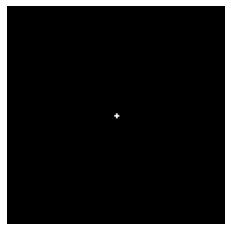

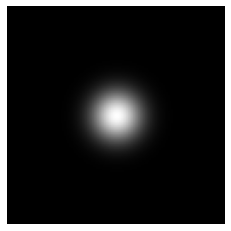

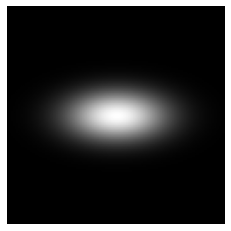

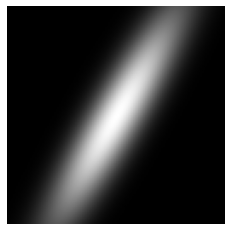

In [15]:
#visualisation des différentes psf sur une étoile isolée

taille_test = 128
image_test_support = np.zeros((taille_test, taille_test))
image_cercle = cv2.circle(image_test_support, (taille_test//2, taille_test//2), 1, 1, -1)
plt.imshow(image_cercle, cmap='gray')
plt.axis("off")
plt.show()

image_cercle0 = blur_image(image_cercle, psf0)
plt.imshow(image_cercle0, cmap='gray')
plt.axis("off")
plt.show()


image_cercle1 = blur_image(image_cercle, psf1)
plt.imshow(image_cercle1, cmap='gray')
plt.axis("off")
plt.show()

image_cercle2 = blur_image(image_cercle, psf2)
plt.imshow(image_cercle2, cmap='gray')
plt.axis("off")

plt.show()

In [16]:
def ame_to_cov(angle=0, magnitude=1, eccentricity=1):
        """
        Convertit les paramètres d'une ellipse (angle, magnitude, eccentricity) en matrice de covariance.
        """
        a = magnitude
        b = a / eccentricity

        # Matrice de rotation
        cos_theta = np.cos(angle)
        sin_theta = np.sin(angle)
        R = np.array([[cos_theta, -sin_theta], [sin_theta, cos_theta]])

        # Matrice de covariance
        D = np.diag([a**2, b**2])
        cov = R.T @ D @ R
        return cov

#### Estimateur de la PSF gaussienne

In [17]:
from skimage.measure import moments, moments_central
from scipy import ndimage

def estimate_gaussian_params(blurred_image, cov = True):
    """
    Estime les paramètres du noyau gaussien à partir d'une image floue.
    Si mode = cov, renvoie la matrice de cov sinon
    Retourne angle, magnitude, eccentricité
    
    Attention : dans une image, la 1ère dimension correspond à y (lignes) et la 2ème à x (colonnes).
    """
    # Calculer les moments centraux d'ordre 2
    Mc = moments_central(blurred_image) 
    # plotter l'erreur 
    # On suppose que Mc[i, j] = E[(y - y_center)^i (x - x_center)^j]
    # Ainsi, la variance en x (horizontal) est donnée par Mc[0, 2] et celle en y par Mc[2, 0]
    
    mu_xx = Mc[0, 2] / Mc[0, 0]  # variance selon x
    mu_yy = Mc[2, 0] / Mc[0, 0]  # variance selon y
    mu_xy = Mc[1, 1] / Mc[0, 0]  # covariance
    
    if cov:
        return np.array([[mu_xx, mu_xy], [mu_xy, mu_yy]])

    temp = np.sqrt((mu_xx - mu_yy)**2 + 4 * mu_xy**2)
    lambda_major = (mu_xx + mu_yy + temp) / 2  # plus grande valeur propre
    lambda_minor = (mu_xx + mu_yy - temp) / 2  # plus petite valeur propre
    
    # Calcul de l'angle : orientation de l'axe majeur par rapport à l'axe x
    angle = 0.5 * np.arctan2(2 * mu_xy, mu_xx - mu_yy)
    
    # Récupérer les écart-types le long des axes principaux
    sigma_major = np.sqrt(lambda_major)
    sigma_minor = np.sqrt(lambda_minor)
    
    # D'après la construction, magnitude = 2*a avec a = sigma_major
    magnitude = 2 * sigma_major
    
    # Eccentricity = b / a = sigma_minor / sigma_major
    eccentricity = sigma_minor / sigma_major if sigma_major != 0 else 0
    
    return angle, magnitude*eccentricity, 1/eccentricity #EDIT : à recorriger pour les bonnes conventions

In [18]:
# Test sur les images floues plus haut
angle, magnitude, eccentricity = estimate_gaussian_params(image_cercle0, cov = False)
print(f"Angle estimé: {angle/np.pi:.2f} pi")
print(f"Magnitude estimée: {magnitude:.2f}")
print(f"Excentricité estimée: {eccentricity:.2f}")
print('Vrai résultat : 0, 10, 1')
print(estimate_gaussian_params(psf0))


print('-------------------------------------------')

angle, magnitude, eccentricity = estimate_gaussian_params(image_cercle1, cov = False)
print(f"Angle estimé: {angle/np.pi:.2f} pi")
print(f"Magnitude estimée: {magnitude:.2f}")
print(f"Excentricité estimée: {eccentricity:.2f}")
print('Vrai résultat : 0, 5, 2')
print(estimate_gaussian_params(psf1))

print('-------------------------------------------')

angle, magnitude, eccentricity = estimate_gaussian_params(image_cercle2, cov = False)
print(f"Angle estimé: {angle/np.pi:.2f} pi")
print(f"Magnitude estimée: {magnitude:.2f}")
print(f"Excentricité estimée: {eccentricity:.2f}")
print('Vrai résultat : pi/3, 10, 5')
print(estimate_gaussian_params(psf2))


print('-------------------------------------------')

psf3 = gaussian_ker(size, np.pi/4, 3, 8)
image_cercle3 = blur_image(image_cercle, psf3)
angle, magnitude, eccentricity = estimate_gaussian_params(image_cercle3, cov = False)
print(f"Angle estimé: {angle/np.pi:.2f} pi")
print(f"Magnitude estimée: {magnitude:.2f}")
print(f"Excentricité estimée: {eccentricity:.2f}")
print('Vrai résultat : pi/4, 3, 8')

Angle estimé: 0.50 pi
Magnitude estimée: 20.04
Excentricité estimée: 1.00
Vrai résultat : 0, 10, 1
[[1.00000000e+02 1.27329258e-11]
 [1.27329258e-11 1.00000000e+02]]
-------------------------------------------
Angle estimé: -0.00 pi
Magnitude estimée: 20.04
Excentricité estimée: 1.98
Vrai résultat : 0, 5, 2
[[ 3.99999997e+02 -1.81898940e-12]
 [-1.81898940e-12  1.00000000e+02]]
-------------------------------------------
Angle estimé: -0.33 pi
Magnitude estimée: 19.90
Excentricité estimée: 3.70
Vrai résultat : pi/3, 10, 5
[[  681.53734593 -1005.47566442]
 [-1005.47566442  1838.28688178]]
-------------------------------------------
Angle estimé: -0.25 pi
Magnitude estimée: 1.45
Excentricité estimée: 4.22
Vrai résultat : pi/4, 3, 8


Test du biais selon plusieurs paramètres

In [ ]:
# biais selon la résolution
c1, c2, c3 = 1,1,1

ker_size = 255
max_res = 15*32
resolutions = np.arange(64,max_res+1,16)

estimates = {}
image_test_support = np.zeros((max_res, max_res))
image_circle = cv2.circle(image_test_support, (max_res//2, max_res//2), 0, 1, -1)


cov = ame_to_cov(0, 8, 1)
psf = gaussian_ker(cov = cov, size=ker_size)

blurred = blur_image(image_circle, psf)

for res in resolutions:
    blurred_low_res = cv2.resize(blurred, (res, res), interpolation=cv2.INTER_AREA) 
    estimate = estimate_gaussian_params(blurred_low_res, cov = True)
    estimates[res] = estimate
    

In [ ]:
# Create lists to store the biases
bias_xx = []
bias_xx_divided = []

# Extract biases for each resolution
for res in resolutions:
    estimate = estimates[res]
    bias_xx.append((estimate[0,0]*(max_res/res)**2 - cov[0,0]))
    bias_xx_divided.append((estimate[0,0]*(max_res/res)**2 - cov[0,0])*res)
    

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(resolutions[:-1], bias_xx[:-1], 'r-o', label='Bias σ²_x')
# plt.plot(resolutions, bias_xx_divided, 'g-o', label='Bias σ_xy')
# plt.plot(resolutions, bias_yy, 'b-o', label='Bias σ²_y')

plt.xlabel('Resolution')
plt.ylabel('Bias')
plt.title(f'Covariance Estimation Bias vs Resolution \n {20}')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Log-log plot of the bias
plt.figure(figsize=(8, 5))
plt.loglog(resolutions[:-2], np.abs(bias_xx[:-2]), 'o-', label=r'$|\mathrm{Bias}_{\sigma^2_x}|$')

# Compute the fitted slope from the data
log_res = np.log(resolutions[:-2])
log_bias = np.log(np.abs(bias_xx[:-2]))

# Plot the reference line with slope -1
reference_line = np.exp(bias_xx[0]+1) / resolutions[:-2]
plt.loglog(resolutions[:-2], reference_line, 'k--', label=r'$x^{-1}$ reference')

# Plot formatting
plt.xlabel('Resolution (log scale)')
plt.ylabel('Bias (log scale)')
# plt.title('Log-log plot of bias vs resolution')
plt.grid(True, which='both', ls='--')
plt.legend()
plt.show()


Test du biais quand on prend une étoile en forme de disque au lieu d'un point

In [ ]:
# Generate test image with circle
size = 256
R = 20
image_test = np.zeros((size, size))
center = (size//2, size//2)
image_circle = cv2.circle(image_test.copy(), center, R, 1, -1)

# Create gaussian kernel
ker_size = 15
sigma_x = 3
sigma_y = 3
angle = 0
cov = ame_to_cov(angle, sigma_x, sigma_y)
psf = gaussian_ker(ker_size, cov=cov)

# Blur the circle
blurred_circle = blur_image(image_circle, psf)

# Compute covariance matrices
cov_circle = estimate_gaussian_params(image_circle, cov=True)
cov_blurred = estimate_gaussian_params(blurred_circle, cov=True)

print("Original circle covariance:")
print(cov_circle)
print("\nGaussian kernel covariance:")
print(cov)
print("\nBlurred circle covariance:")
print(cov_blurred)

# Visualize results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.imshow(image_circle, cmap='gray')
ax1.set_title('Original Circle')
ax2.imshow(blurred_circle, cmap='gray')
ax2.set_title('Blurred Circle')
plt.show()

Autre test du biais selon la résolution ET l'amplitude du flou

In [ ]:
# Test different magnitudes and resolutions
magnitudes = [10, 20, 30, 40]  # Different values of lambda1
ker_size = 255
max_res = 384
resolutions = np.arange(32, max_res+1, 32)

# Dictionary to store results for each magnitude
all_estimates = {}

for magnitude in magnitudes:
    estimates = {}
    image_test_support = np.zeros((max_res, max_res))
    image_circle = cv2.circle(image_test_support, (max_res//2, max_res//2), 1, 1, -1)
    
    # Generate PSF with current magnitude
    cov = ame_to_cov(0, magnitude, 1.8)
    psf = gaussian_ker(cov=cov, size=ker_size)
    blurred = blur_image(image_circle, psf)
    
    # Test different resolutions
    for res in resolutions:
        blurred_low_res = cv2.resize(blurred, (res, res), interpolation=cv2.INTER_AREA) 
        estimate = estimate_gaussian_params(blurred_low_res, cov=True)
        estimates[res] = estimate
    
    all_estimates[magnitude] = estimates

# Create the plot
plt.figure(figsize=(12, 8))

# Plot bias_xx for each magnitude
for magnitude in magnitudes:
    estimates = all_estimates[magnitude]
    bias_xx = []
    
    # Calculate bias for each resolution
    for res in resolutions:
        estimate = estimates[res]
        bias_xx.append((estimate[0,0]*(max_res/res)**2 - cov[0,0])/cov[0,0])
    
    plt.plot(resolutions, bias_xx, '-o', label=f'C_11 = {magnitude}')

plt.xlabel('Resolution')
plt.ylabel('Bias C_11/C_11')
plt.title('Covariance Estimation Bias vs Resolution for Different Magnitudes')
plt.grid(True)
plt.legend()
plt.show()

#### Convolution spatialement variante:  
kernels sera un tableau de shape [img_h, img_w, ker_h, ker_w] tel que kernels[i,j]
est le noyau de convolution au pixel i,j

In [ ]:
# Génération d'un champ d'étoiles avec des étoiles espacées
star_field, star_pos = generate_spaced_star_field(image_shape= (512,512), num_stars= 25, star_radius=0)

# Affichage de l'image
plt.figure(figsize=(8, 8))
plt.imshow(star_field, cmap='gray')
plt.show()

NameError: name 'generate_spaced_star_field' is not defined

In [ ]:
def spatially_variant_convolution(image, kernels):
    img_h, img_w = image.shape
    ker_h, ker_w = kernels.shape[2], kernels.shape[3]
    pad_h, pad_w = ker_h // 2, ker_w // 2

    # Pad the image
    padded_image = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant')

    # Extract patches: shape (img_h, img_w, ker_h, ker_w)
    shape = (img_h, img_w, ker_h, ker_w)
    strides = padded_image.strides[:2] + padded_image.strides[:2]
    patches = np.lib.stride_tricks.as_strided(padded_image, shape=shape, strides=strides)

    # Perform element-wise multiplication and summation
    output = np.einsum('ijkl,ijkl->ij', patches, kernels)

    return output

Blur constant pour tester

In [ ]:
kersize = 15
psftest = gaussian_ker(kersize, 0, 2, 1)

kernels_test = np.zeros(star_field.shape + (kersize, kersize))
kernels_test[:,:] = psftest
image_blurred = spatially_variant_convolution(star_field, kernels_test)

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(star_field, cmap='gray')
plt.title('Original Star Field')
plt.subplot(122)
plt.imshow(image_blurred, cmap='gray')
plt.title('Blurred Star Field')
plt.show()

Création d'une PSF spatialement variante et test

In [ ]:
def example_generate_variable_kernel(image_shape, kersize):
    img_h, img_w = image_shape
    kernels = np.zeros((img_h, img_w, kersize, kersize))

    for i in range(img_h):
        for j in range(img_w):
            angle = np.arctan2(j, i) + np.pi/2 #pointe vers le coin
            magnitude = 3.4*np.sqrt(i**2 + j**2)/img_h + 0.3
            eccentricity = 1*np.sqrt((i**2 + j**2))/img_h + 0.5
            kernels[i, j] = gaussian_ker(kersize, angle, magnitude, eccentricity)

    return kernels

# Generate the variable kernel
image_shape = star_field.shape
kersize = 63

variable_kernels = example_generate_variable_kernel(image_shape, kersize)

# Apply the spatially variant convolution
image_blurred_variable = spatially_variant_convolution(star_field, variable_kernels)

# Display the result
plt.figure(figsize=(13, 6))
plt.axis('off')
plt.imshow(image_blurred_variable, cmap='gray')
plt.show()

#### Découpeur par patches puis estimateur par patch

In [ ]:
def crop_patches(image: np.ndarray, coordinates: list, half_side: int) -> list:
    """
    Crop square patches from the image centered at given coordinates.
    Pads the image before cropping to handle border cases.

    Parameters:
    - image: 2D numpy array (grayscale image)
    - coordinates: list of (row, col) tuples (integers)
    - half_side: half the side length of the square crop

    Returns:
    - List of 2D numpy arrays corresponding to the cropped patches
    """
    padded_image = np.pad(
        image,
        pad_width=half_side,
        mode='constant',
        constant_values=0
    )

    patches = []

    for (row, col) in coordinates:
        # Shift coordinates due to padding
        row_p, col_p = row + half_side, col + half_side
        patch = padded_image[row_p - half_side:row_p + half_side + 1,
                             col_p - half_side:col_p + half_side + 1]
        patches.append(patch)

    return patches

def gaussian_estimate_bypatch(image: np.ndarray, coordinates: list, half_side: int):
    patches = crop_patches(image, coordinates, half_side)
    return coordinates, [estimate_gaussian_params(patch) for patch in patches]

Test sur l'image

In [ ]:
patches = crop_patches(image_blurred_variable, star_pos, 15)
for p in patches:
    plt.imshow(p, cmap = 'gray')
    plt.show()

Estimateur de la covariance locale sur les patchs. À améliorer parce que sur les vraies images, il y a plusieurs étoiles dans un patch.

In [ ]:
def local_estimation(patches):
    center = np.unravel_index(np.argmax(patches[0], axis=None), patches[0].shape)
    covs = []
    for p in patches:
        Mc = moments_central(p, center)
        mu_xx = Mc[0, 2] / Mc[0, 0]  # variance selon x
        mu_yy = Mc[2, 0] / Mc[0, 0]  # variance selon y
        mu_xy = Mc[1, 1] / Mc[0, 0]  # covariance

        covs.append( np.array([[mu_xx, mu_xy], [mu_xy, mu_yy]]))

    return covs

In [ ]:
covariances_estimates = local_estimation(patches)

In [ ]:
known_covariances = np.array([variable_kernels[tuple(pos)] for pos in star_pos])

#### Interpolateur de matrices de cov de PSF avec kringeage

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from scipy.linalg import logm, expm

def interpolate_cov_field(known_positions, known_covariances, image_shape):
    """
    Interpolate Gaussian blur kernels across an image using Gaussian Process Regression.
    
    Parameters:
    - known_positions: array (n_samples, 2) coordinates of stars
    - known_covariances: array (n_samples, 2, 2) covariance at each star
    - image_shape: (height, width)
    
    Returns:
    - interpolated_covariances: array of shape (height, width, 2, 2)
    """
    # Convert covariance matrices to their matrix logarithm
    # This maps SPD matrices to the space of symmetric matrices
    log_covs = np.array([logm(cov) for cov in known_covariances])
    
    # Create target positions grid
    y, x = np.meshgrid(np.arange(image_shape[0]), np.arange(image_shape[1]), indexing='ij')
    target_positions = np.column_stack((y.ravel(), x.ravel()))
    
    # Define kernel with length scale related to image size
    length_scale = image_shape[0] #For now kernels are the same lengths as the image...
    kernel = RBF(length_scale=length_scale) + WhiteKernel(noise_level=1e-5)
    #A FAIRE : peut être adapter le noise_level au bruit mesuré dans l'image
    
    # Fit GP for the entire matrix logarithm
    gp = GaussianProcessRegressor(kernel=kernel)
    gp.fit(known_positions, log_covs.reshape(len(known_positions), -1))
    
    # Predict and reshape back to covariance matrices
    log_predictions = gp.predict(target_positions)
    log_predictions = log_predictions.reshape(-1, 2, 2)
    
    # Convert back to covariance matrices using matrix exponential
    interpolated_covariances = np.array([expm(log_pred) for log_pred in log_predictions])
    
    # Reshape to image dimensions
    interpolated_covariances = interpolated_covariances.reshape(
        image_shape[0], image_shape[1], 2, 2)
    
    return interpolated_covariances

Application à notre image

In [ ]:
# TEST de l'interpolation

def example2_generate_variable_kernel(image_shape, kersize):
    img_h, img_w = image_shape
    kernels = np.zeros((img_h, img_w, kersize, kersize))
    cov_variable = np.zeros((img_h, img_w, 2, 2))

    for i in range(img_h):
        for j in range(img_w):
            cov = np.zeros((2,2))
            cov[0,0] = (i**2 + j**2)/img_h**2 + 1
            cov[1,1] = 0.5*np.sqrt(i**2 + j**2)/img_h + 0.1
            cov[1,0] = 0.3*(i**2 + j**2)/img_h**2
            cov[0,1] = 0.3*(i**2 + j**2)/img_h**2
            cov_variable[i,j] = cov
            kernels[i, j] = gaussian_ker(kersize, cov=cov)

    return kernels, cov_variable #KEEP TRACK OF THE COVARIANCE MATRIX AT EACH POINT

kernels, covariances = example2_generate_variable_kernel(star_field.shape, 15)
blurred_starfield = spatially_variant_convolution(star_field, kernels)

known_positions = star_pos #shape (10,2)
known_covariances = np.array([covariances[tuple(pos)] for pos in known_positions]) #shape (10,2,2)

interpolated = interpolate_cov_field(known_positions, known_covariances, star_field.shape)

In [ ]:
diff = interpolated-covariances
errors = np.linalg.norm(diff, ord='fro', axis=(2,3))
rel_errors = np.linalg.norm(diff, ord='fro', axis=(2,3)) / np.linalg.norm(covariances, ord='fro', axis=(2,3))
rel_errors.mean()

In [ ]:
interpolated[0,0,:,:]

In [ ]:
plt.figure(figsize=(10, 5))
plt.imshow(blurred_starfield, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
plt.imshow(errors)
plt.axis('off')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
im = ax.imshow(rel_errors, cmap='viridis')
ax.axis('off')

# Plot red crosses at each star position
for y, x in star_pos:
    ax.plot(x, y, marker='+', color='red', markersize=8, markeredgewidth=1.5)


plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.show()

Code qui prend une image et trouve les positions des étoiles. Il y a d'autres méthodes plus performantes.

In [ ]:
from photutils.detection import DAOStarFinder, IRAFStarFinder

def detect_stars(image, threshold=0.99):
    """Detect star in an image using DAOStarFinder.
    
    Inputs :
    image : 2D array, the image.
    threshold : float, the threshold for detection.
    
    Returns :
    sources : Table, the detected stars
    """
    
    # Subtract the mean of the image
    mean = np.mean(image)
    image_subtracted = image - mean
    # Setup the DAOStarFinder with appropriate threshold and FWHM
    daofind = DAOStarFinder(threshold=threshold, fwhm=2, brightest=30) #3 because the image has been created with 3pixels FWHM
    sources = daofind.find_stars(image_subtracted)
    return sources

In [ ]:
real_image = cv2.imread('images/original/PXL-4-cropped.jpg', cv2.IMREAD_GRAYSCALE)
real_image.shape

In [ ]:
from photutils.detection import DAOStarFinder, IRAFStarFinder
import numpy as np

def detect_stars(image, threshold=0.99, method="DAO", fwhm=2, brightest=30):
    """
    Detect stars in an image using DAOStarFinder or IRAFStarFinder.
    
    Parameters:
    ----------
    image : 2D array
        The input image.
    threshold : float, optional
        The threshold for detection (default: 0.99).
    method : str, optional
        The method to use for star detection ("DAO" or "IRAF", default: "DAO").
    fwhm : float, optional
        Full width at half maximum of the stars (default: 2).
    brightest : int, optional
        Maximum number of brightest stars to detect (default: 30).
    
    Returns:
    -------
    detected_positions : ndarray
        Array of shape (n_stars, 2) containing (y, x) coordinates of detected stars.
    sources : Table
        The full table of detected stars with additional information.
    """
    # Subtract the mean of the image
    mean = np.mean(image)
    image_subtracted = image - mean
    
    # Choose the star finder method
    if method == "DAO":
        star_finder = DAOStarFinder(threshold=threshold, fwhm=fwhm, brightest=brightest)
    elif method == "IRAF":
        star_finder = IRAFStarFinder(threshold=threshold, fwhm=fwhm, brightest=brightest)
    else:
        raise ValueError("Invalid method. Choose 'DAO' or 'IRAF'.")
    
    # Detect stars
    sources = star_finder.find_stars(image_subtracted)
    
    # Extract (y, x) positions of detected stars
    if sources is not None:
        detected_positions = np.array([sources['ycentroid'], sources['xcentroid']]).T
    else:
        detected_positions = np.empty((0, 2))  # No stars detected
    
    return detected_positions, sources

Comparaison des différentes méthodes

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from skimage.feature import peak_local_max
from astropy.stats import sigma_clipped_stats

def advanced_star_detection(image, sigma_threshold=3, fwhm=3):
    """
    Advanced star detection with multiple robustness features
    
    Parameters:
    - image: Input image
    - sigma_threshold: Detection threshold in sigma units
    - fwhm: Approximate Full Width at Half Maximum
    
    Returns:
    - Detected star sources
    """
    # Robust background estimation
    mean, _,std = sigma_clipped_stats(image)
    
    # Detect local peaks using difference of Gaussian
    dog = ndimage.gaussian_filter(image, sigma=fwhm) - \
          ndimage.gaussian_filter(image, sigma=fwhm*1.5)
    
    # Find local maxima above threshold
    threshold = mean + (sigma_threshold * std)
    peaks = peak_local_max(
        dog, 
        min_distance=int(fwhm), 
        threshold_abs=threshold,
        exclude_border=True
    )
    
    # Compute centroid and additional star characteristics
    star_sources = []
    for peak in peaks:
        y, x = peak
        # Extract local region
        region = image[max(0, y-fwhm):min(image.shape[0], y+fwhm+1),
                      max(0, x-fwhm):min(image.shape[1], x+fwhm+1)]
        
        # Compute centroid with weighted center of mass
        total = np.sum(region)
        y_coords, x_coords = np.indices(region.shape)
        weighted_y = np.sum(region * y_coords) / total + (y - fwhm)
        weighted_x = np.sum(region * x_coords) / total + (x - fwhm)
        
        star_sources.append([weighted_x, weighted_y])

    
    return np.array(star_sources)

def visualize_detected_stars(real_image, dao_positions, iraf_positions, output_path="detected_stars_comparison.png"):
    """
    Visualize the detected stars from DAOStarFinder and IRAFStarFinder on the original image.
    
    Parameters:
    ----------
    real_image : ndarray
        The original image.
    dao_positions : ndarray
        Array of shape (n_dao_stars, 2) with (y, x) coordinates of stars detected by DAOStarFinder.
    iraf_positions : ndarray
        Array of shape (n_iraf_stars, 2) with (y, x) coordinates of stars detected by IRAFStarFinder.
    output_path : str, optional
        Path to save the resulting image (default: "detected_stars_comparison.png").
    """
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(real_image, cmap='gray', origin='lower')
    
    # Plot DAO detected stars in green
    for pos in dao_positions:
        circle = Circle((pos[1], pos[0]), radius=7, edgecolor='green', facecolor='none', lw=2, label='DAO Detected')
        ax.add_patch(circle)
    
    # Plot IRAF detected stars in red
    for pos in iraf_positions:
        circle = Circle((pos[1], pos[0]), radius=13, edgecolor='red', facecolor='none', lw=2, label='IRAF Detected')
        ax.add_patch(circle)
    
    # Add legend and labels
    handles = [
        Circle((0, 0), radius=7, edgecolor='green', facecolor='none', lw=2, label='DAO Detected'),
        Circle((0, 0), radius=13, edgecolor='red', facecolor='none', lw=2, label='IRAF Detected')
    ]
    ax.legend(handles=handles, loc='upper right')
    ax.set_title("Star Detection: DAO (Green) vs IRAF (Red)")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    
    # Save the image
    plt.savefig(output_path, dpi=5, pad_inches = 0, bbox_inches='tight')
    print(f"Image saved to {output_path}")
    plt.close(fig)


# Detect stars using DAOStarFinder
dao_positions, dao_sources = detect_stars(real_image, threshold=0.99, method="DAO")

# Detect stars using IRAFStarFinder
iraf_positions, iraf_sources = detect_stars(real_image, threshold=0.99, method="IRAF")

# Detect using manual method
star_sources = advanced_star_detection(real_image, sigma_threshold=33, fwhm=70)

star_sources.shape
# Visualize and save the comparison
# visualize_detected_stars(real_image, dao_positions, iraf_positions, output_path="detected_stars_comparison.png")

In [ ]:
def visualize_detected_stars(real_image, dao_positions, iraf_positions, our_positions, output_path="detected_stars_comparison.png"):
    """
    Visualize the detected stars from DAOStarFinder, IRAFStarFinder, and our custom method on the original image.
    
    Parameters:
    ----------
    real_image : ndarray
        The original image.
    dao_positions : ndarray
        Array of shape (n_dao_stars, 2) with (y, x) coordinates of stars detected by DAOStarFinder.
    iraf_positions : ndarray
        Array of shape (n_iraf_stars, 2) with (y, x) coordinates of stars detected by IRAFStarFinder.
    our_positions : ndarray
        Array of shape (n_our_stars, 2) with (y, x) coordinates of stars detected by our method.
    output_path : str, optional
        Path to save the resulting image (default: "detected_stars_comparison.png").
    """
    fig, ax = plt.subplots(figsize=(12, 12))
    plt.axis('off')
    ax.imshow(real_image, cmap='gray', origin='lower')

    # Plot DAO detected stars in green
    for pos in dao_positions:
        circle = Circle((pos[1], pos[0]), radius=6, edgecolor='green', facecolor='none', lw=1.5, alpha = 0.4)
        ax.add_patch(circle)

    # Plot IRAF detected stars in red
    for pos in iraf_positions:
        circle = Circle((pos[1], pos[0]), radius=11, edgecolor='red', facecolor='none', lw=1.5, alpha = 0.4)
        ax.add_patch(circle)

    # Plot our method detected stars in yellow
    for pos in our_positions:
        circle = Circle((pos[1], pos[0]), radius=15, edgecolor='yellow', facecolor='none', lw=1.5, alpha = 0.4)
        ax.add_patch(circle)

    # Add legend
    handles = [
        Circle((0, 0), radius=6, edgecolor='green', facecolor='none', lw=1.3, label='DAO Detected'),
        Circle((0, 0), radius=11, edgecolor='red', facecolor='none', lw=1.3, label='IRAF Detected'),
        Circle((0, 0), radius=15, edgecolor='yellow', facecolor='none', lw=1.3, label='Our Method')
    ]

    # Save the image
    # plt.legend()
    plt.savefig(output_path, dpi=500, pad_inches = 0, bbox_inches='tight')
    print(f"Image saved to {output_path}")
    plt.close(fig)

# Visualize and save the comparison
visualize_detected_stars(real_image, dao_positions, iraf_positions, star_sources, output_path="detected_stars_comparison2.png")

We decided that DAO gives better results

#### Fin

Code qui prend une image, la liste des pos des étoiles et renvoie la liste des cov

In [ ]:
def estimate_star_covariances(image, star_positions, patch_size=15):
    """
    Estimate the covariance matrices of gaussian blur for each detected star.
    
    Parameters:
    ----------
    image : 2D array
        The input image
    star_positions : ndarray
        Array of shape (n_stars, 2) containing (y, x) coordinates of detected stars
    patch_size : int
        Size of the patch around each star to analyze (should be odd)
    
    Returns:
    -------
    covariances : ndarray
        Array of shape (n_stars, 2, 2) containing the covariance matrix for each star
    """
    half_size = patch_size // 2
    covariances = []
    
    for pos in star_positions:
        y, x = int(pos[0]), int(pos[1])
        
        # Extract patch around the star
        patch = image[max(0, y-half_size):min(image.shape[0], y+half_size+1),
                     max(0, x-half_size):min(image.shape[1], x+half_size+1)]
        
        try:
            # Get covariance matrix from moments
            cov = estimate_gaussian_params(patch, cov=True)
            covariances.append(cov)
        except ValueError:
            # If estimation fails, append identity matrix
            covariances.append(np.eye(2))
    
    return np.array(covariances)

EVALUATION : MESURE DES COVARIANCES vs COVARIANCES REELES image simulée, ker variable

In [ ]:
kernels, covariances = example2_generate_variable_kernel(star_field.shape, 15)
blurred_starfield = spatially_variant_convolution(star_field, kernels)

known_positions = star_pos #shape (10,2)
known_covariances = np.array([covariances[tuple(pos)] for pos in known_positions]) #shape (10,2,2)

plt.imshow(blurred_starfield, cmap='gray')

In [ ]:
estimated_covariances = estimate_star_covariances(blurred_starfield, known_positions, patch_size=8)

In [ ]:
estimated_covariances[0]

In [ ]:
plt.imshow(star_field, cmap='gray')